In [6]:
import importlib
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Import relevant python packages
from gpet import utils, gpet, dataset
%matplotlib inline

In [7]:
importlib.reload(gpet)
importlib.reload(utils)
importlib.reload(dataset)

<module 'gpet_oct.dataset' from '/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/gpet_oct/dataset.py'>

### Loading and splitting the dataset
Here the dataset is loaded as scans and masks and split into an **80-20 train-test** split. This results in **4192 train** samples from and **1048 test** samples.

In [9]:
scan_dir = '../data/scans'
mask_dir = '../data/masks'

# Get the list of scan and mask filenames
scan_files = os.listdir(scan_dir)
mask_files = os.listdir(mask_dir)

# Ensure the filenames match between scans and masks
assert len(scan_files) == len(mask_files), "Number of scans and masks do not match!"
for scan_file, mask_file in zip(scan_files, mask_files):
    assert scan_file == mask_file, f"Scan file {scan_file} does not match mask file {mask_file}!"

# Split the filenames into train and test sets
train_files, test_files = train_test_split(scan_files, test_size=0.2, random_state=42)

### Preprocessing the data
Here I preprocess the dataset so that:
- The scans and the masks are **resized** to be the same shape, here I pick (350, 500) since it's the average shape
- The scans are made to be true **grayscale**
- The masks are used to extract the coordinates of the **groundtruth edge** (ELM)

In [10]:
# Load the training data
train_scans, train_elm_coords = dataset.load_dataset(train_files, scan_dir, mask_dir)

# Load the testing data
test_scans, test_elm_coords = dataset.load_dataset(test_files, scan_dir, mask_dir)

# Print some information about the loaded data
print(f"Number of training samples: {len(train_scans)}")
print(f"Number of testing samples: {len(test_scans)}")
print(f"Shape of first training scan: {train_scans[0].shape}")  # Checking the resizing was done correctly
print(f"Number of ELM coordinates in first training mask: {len(train_elm_coords[0])}")

Number of training samples: 4192
Number of testing samples: 1048
Shape of first training scan: (350, 500)
Number of ELM coordinates in first training mask: 2159


In [11]:
# Test the function using a singular scan
test_idx = 0
test_scan = train_scans[test_idx]
test_elm = train_elm_coords[test_idx]

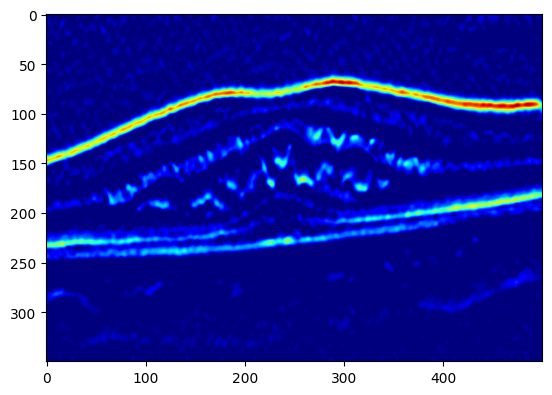

In [12]:
# Create a kernel for edge detection
kernel = utils.kernel_builder(size=(21, 5), unit=False, normalize=True)
# Compute the gradient image
test_edge_map = utils.comp_grad_img(test_scan, kernel)

plt.imshow(test_edge_map, cmap='jet')

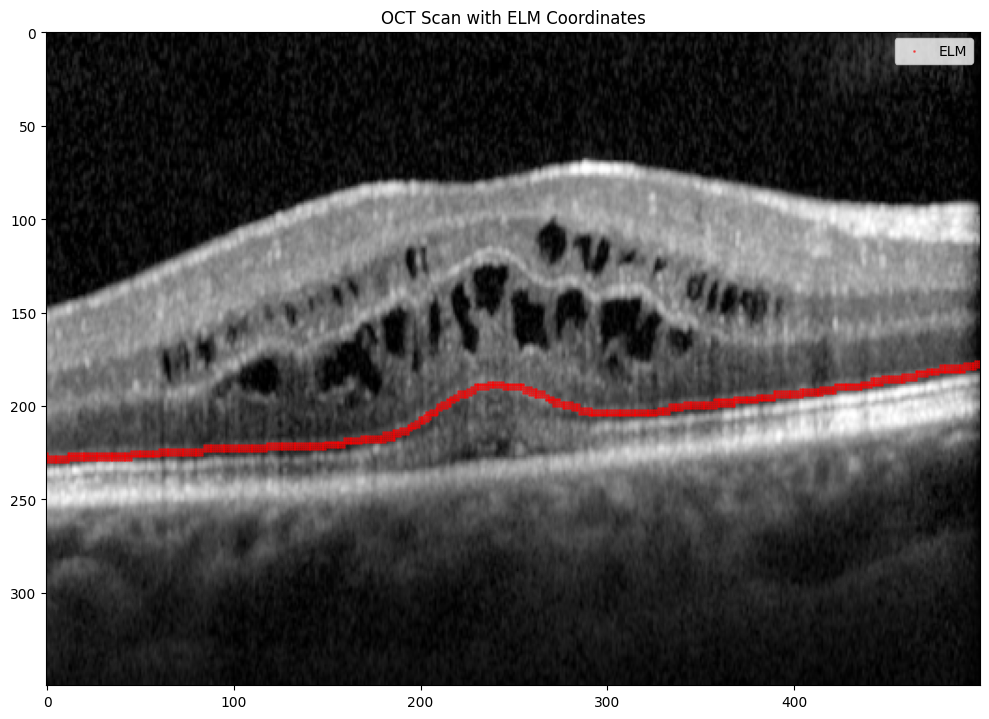

In [13]:
utils.plot_elm(test_scan, test_elm)

In [14]:
test_elm

array([[176, 497],
       [176, 498],
       [176, 499],
       ...,
       [230,   9],
       [230,  10],
       [230,  11]])

In [15]:
# Get initialization edges from the true_elm_coords aka mask
init = test_elm[[0, -1], :][:, [1, 0]]
# Switch rows so the x's are in ascending order
init[[0, 1]] = init[[1, 0]]
init

array([[ 11, 230],
       [497, 176]])

# TODO: TRY TO DO COMBINE KERNELS TO GET BETTER RESULTS.
*MIGHT BE EXP.*


In [16]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True
)

# Instantiate algorithm using parameters in __init__()
noisy_trace = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs)

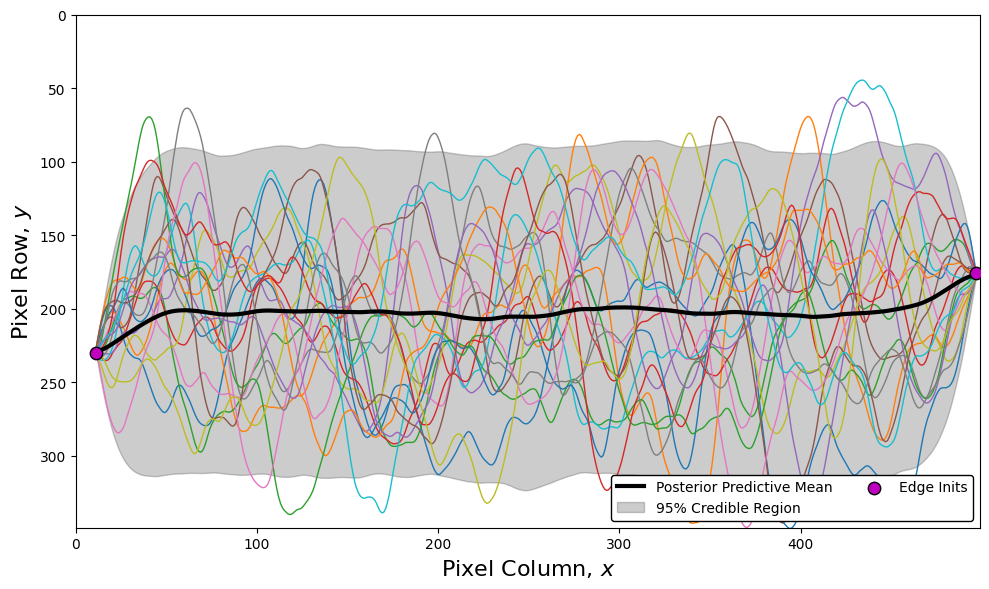

Are you happy with your choice of kernel? y/n
Fitting Gaussian process and computing next set of observations...


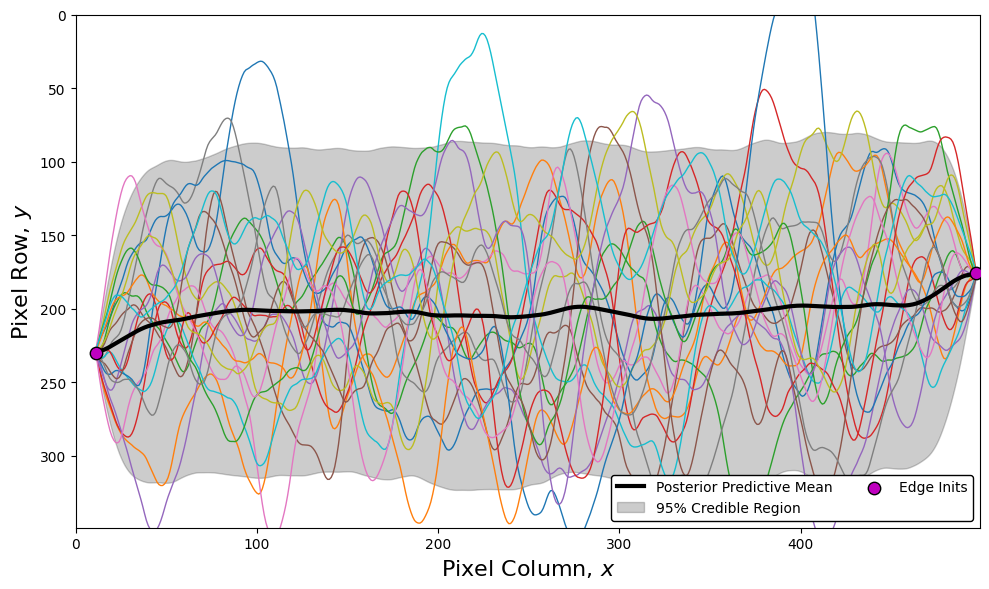

Number of observations: 8
Iteration 2 - Time Elapsed: 1.0193


Fitting Gaussian process and computing next set of observations...


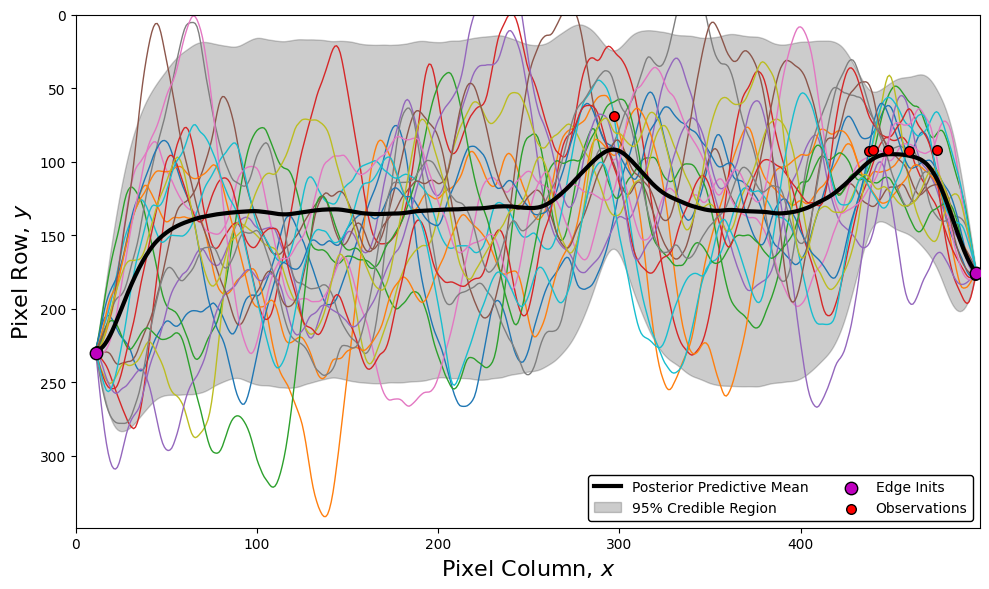

Number of observations: 18
Iteration 3 - Time Elapsed: 0.9662


Fitting Gaussian process and computing next set of observations...


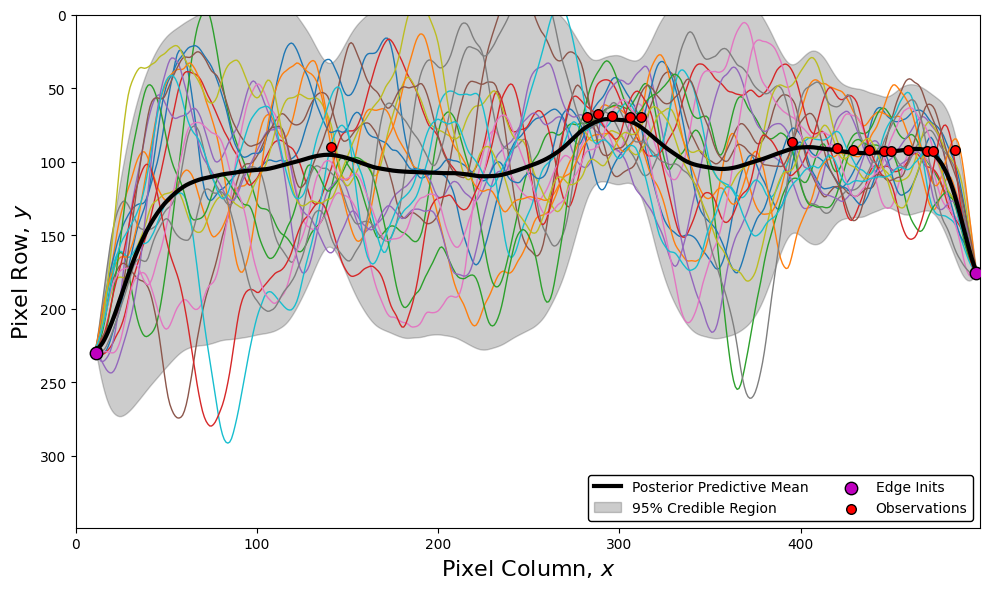

Number of observations: 26
Iteration 4 - Time Elapsed: 1.1006


Fitting Gaussian process and computing next set of observations...


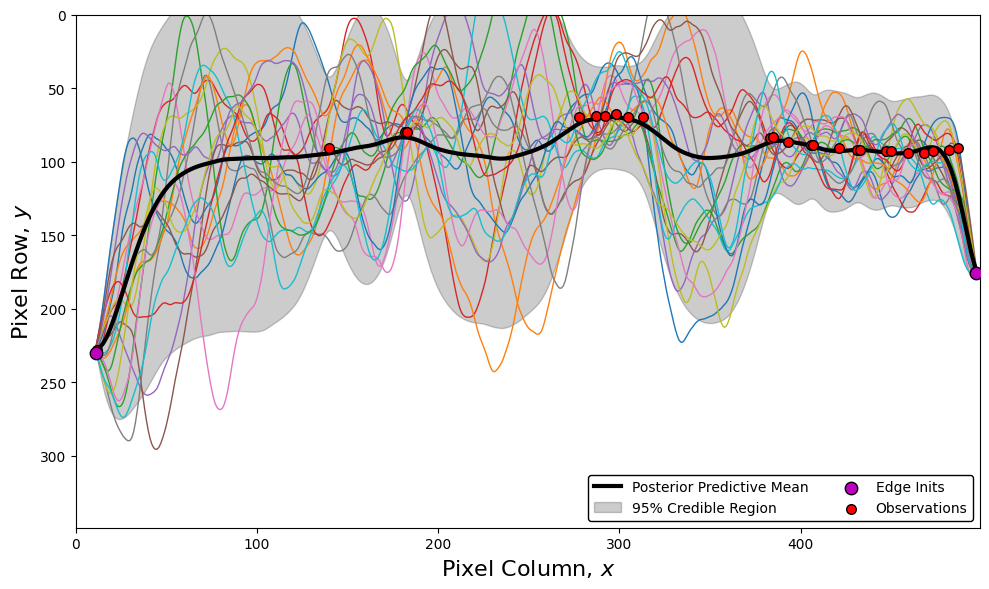

Number of observations: 33
Iteration 5 - Time Elapsed: 0.8965


Fitting Gaussian process and computing next set of observations...


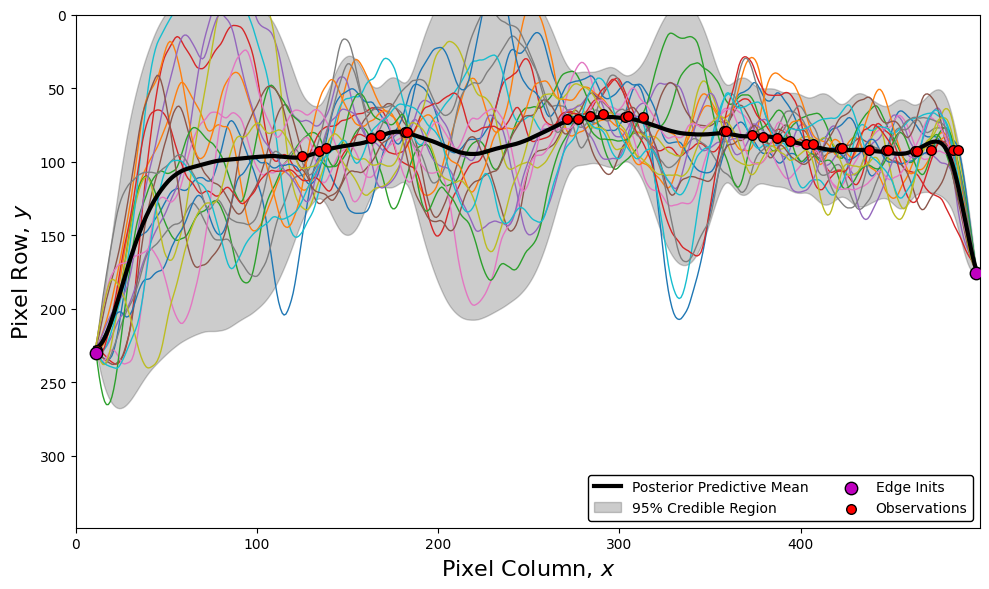

Number of observations: 43
Iteration 6 - Time Elapsed: 0.9081


Fitting Gaussian process and computing next set of observations...


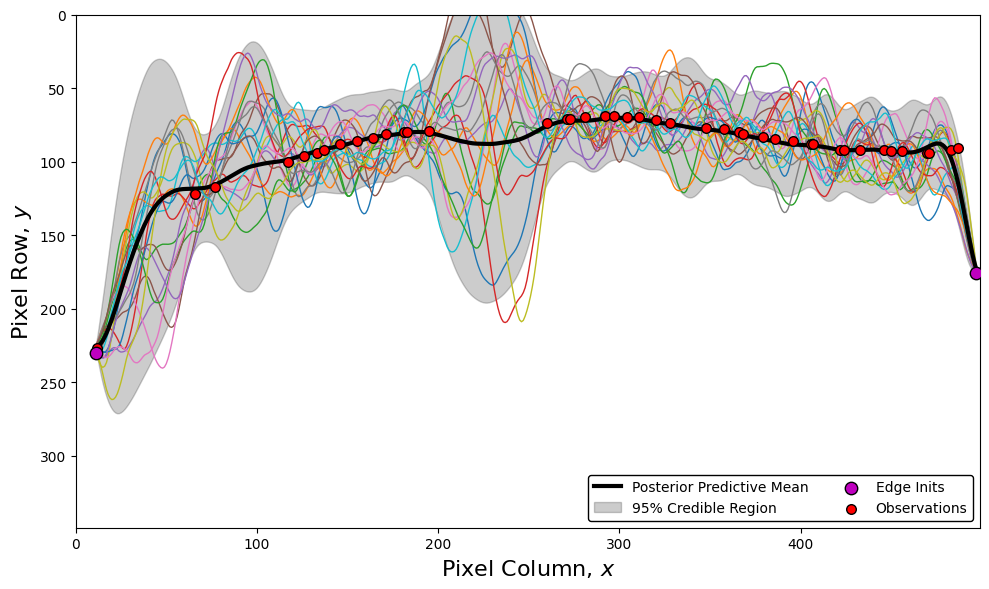

Number of observations: 49
Iteration 7 - Time Elapsed: 0.8876


Fitting Gaussian process and computing next set of observations...


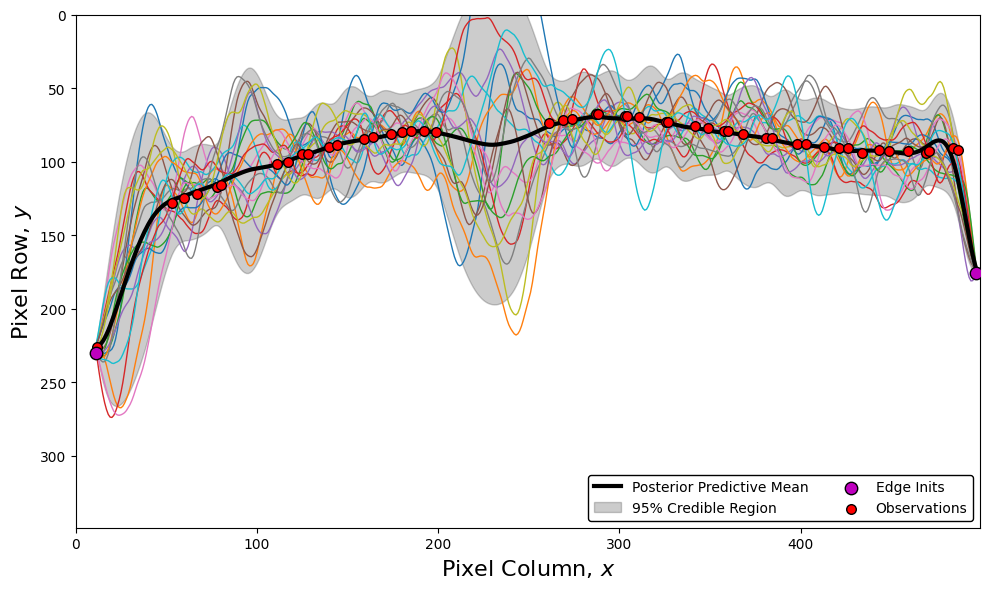

Number of observations: 54
Iteration 8 - Time Elapsed: 0.9035


Fitting Gaussian process and computing next set of observations...


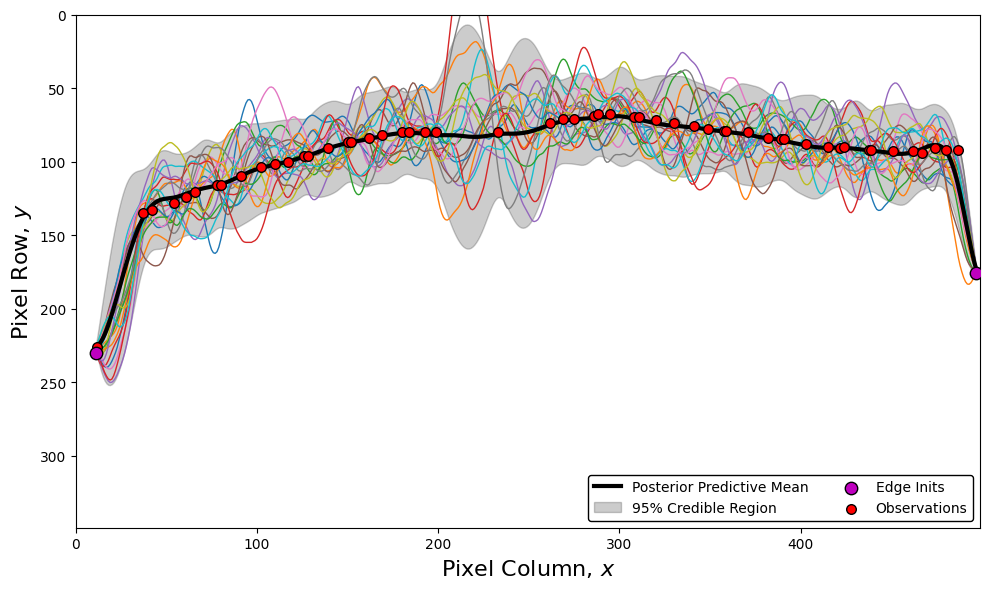

Number of observations: 58
Iteration 9 - Time Elapsed: 0.8509


Time elapsed before algorithm converged: 7.998


In [17]:
# __call__() parameters and run algorithm on test image
print_final_diagnostics = False
show_init_post = True
show_post_iter = True
verbose = True
edge_pred, edge_credint = noisy_trace(print_final_diagnostics,
                                      show_init_post,
                                      show_post_iter,
                                      verbose)

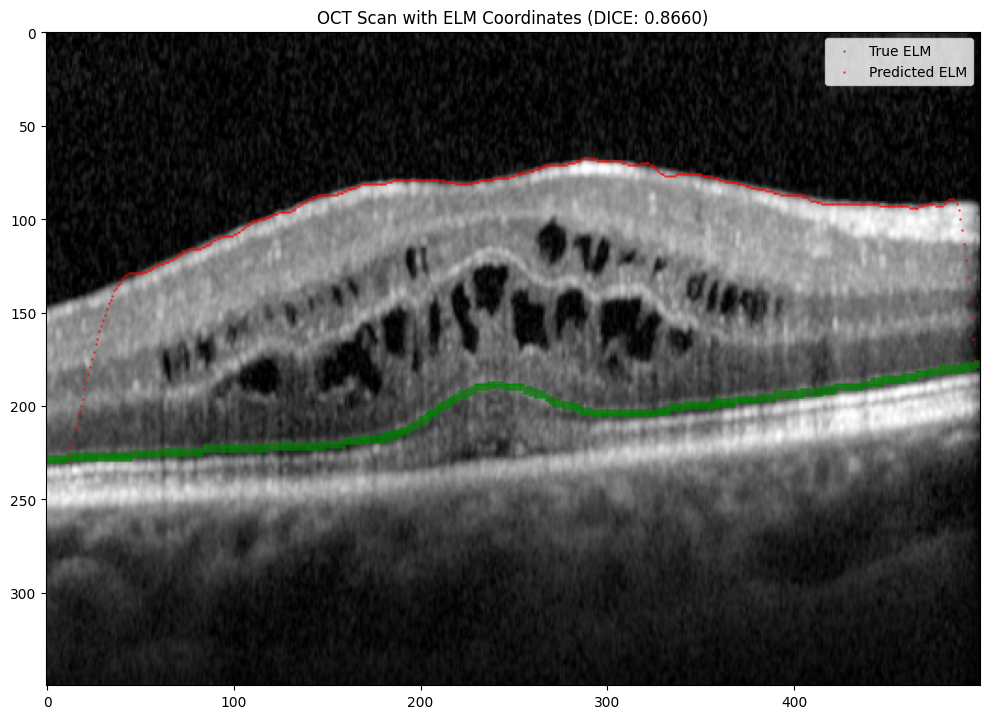

In [18]:
utils.plot_elm(test_scan, edge_pred, compare=True, true_elm_coords=test_elm)

**Experimenting with the use of the variable `obs`**

In [19]:
test_elm

array([[176, 497],
       [176, 498],
       [176, 499],
       ...,
       [230,   9],
       [230,  10],
       [230,  11]])

**Here I randomly select 100 xy-points as the `obs` variable.**

In [42]:
# Randomly select 100 rows
test_obs = test_elm[np.random.choice(test_elm.shape[0], size=100, replace=False), :]
test_obs = test_obs[test_obs[:, 0].argsort()]

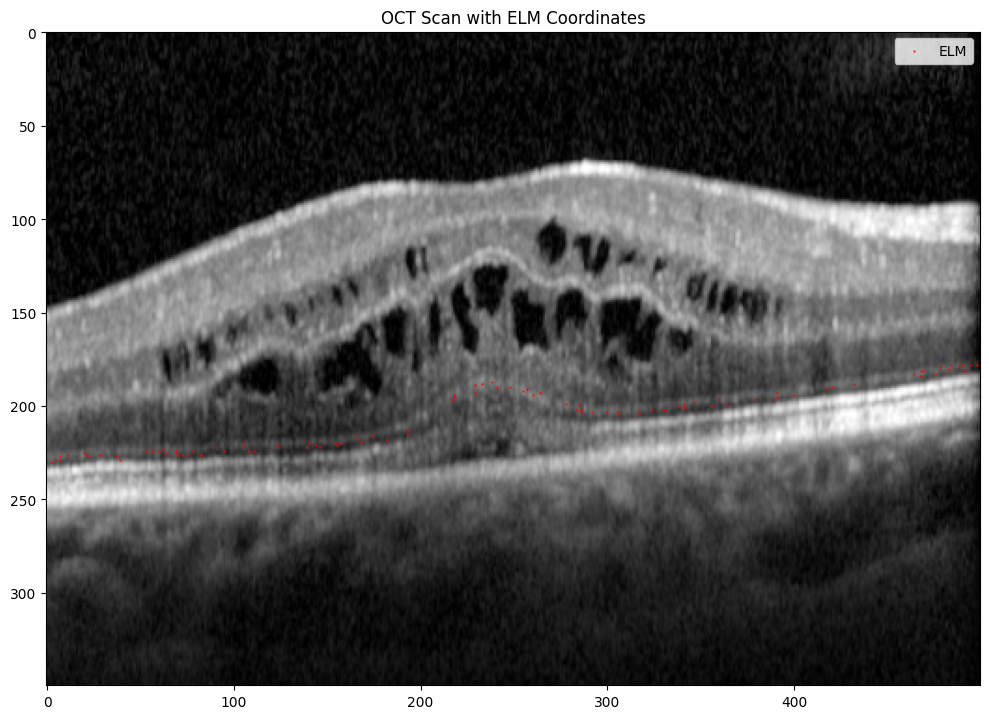

In [43]:
utils.plot_elm(test_scan, test_obs)

In [44]:
test_obs[:, [0, 1]] = test_obs[:, [1, 0]]  # yx-plane to xy-plane

In [45]:
gp_kwargs_obs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs=test_obs
)

# Instantiate algorithm using parameters in __init__()
noisy_trace_w_obs = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs)

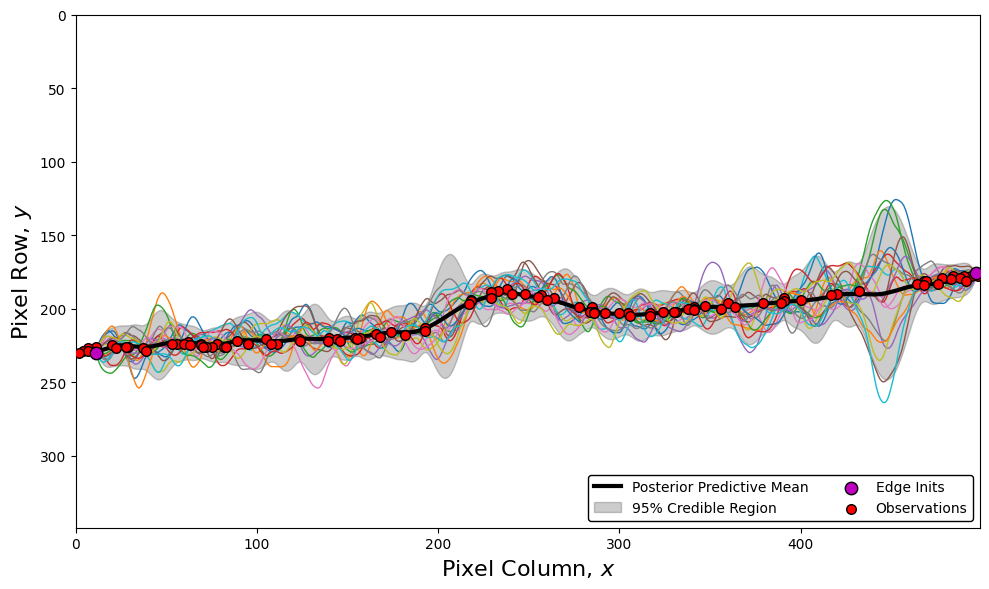

Are you happy with your choice of kernel? y/n
Time elapsed before algorithm converged: 0.633


In [46]:
# __call__() parameters and run algorithm on test image
print_final_diagnostics = False
show_init_post = True
show_post_iter = True
verbose = True
edge_pred_obs, edge_credint_obs = noisy_trace_w_obs(print_final_diagnostics,
                                                    show_init_post,
                                                    show_post_iter,
                                                    verbose)

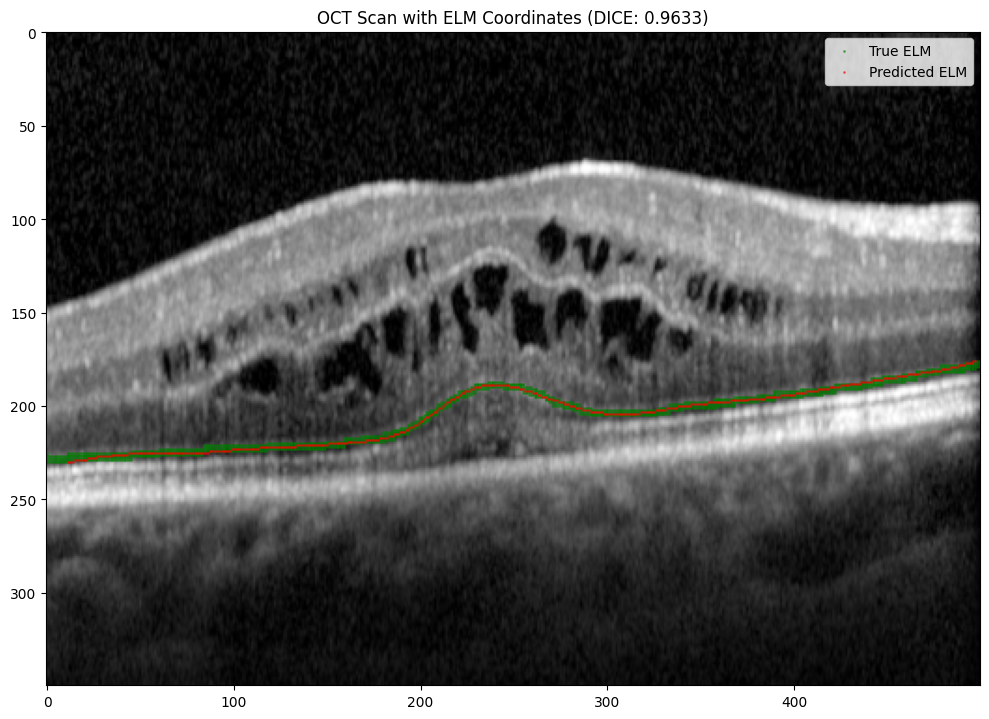

In [47]:
utils.plot_elm(test_scan, edge_pred_obs, compare=True, true_elm_coords=test_elm)

**In reality, we will not have the luxury of having the masks for the ELM annotations hence this is impractical, but I will implement the Bayesian Recursive Scheme where the `obs` variable will be dependent on the prior scans and their predictions, or a subset will be predetermined to come up with knowledge.**

**Now, we will try to improve the accuracy of the model by selecting linearly spaced xy-points from `test_elm_coords`.**

In [62]:
num_rows = test_elm.shape[0]

start, stop = 0, num_rows - 1
row_indices = np.linspace(start, stop, num=50, dtype=int)

test_obs_lp = test_elm[row_indices, :]

test_obs_lp = test_obs_lp[test_obs_lp[:, 0].argsort()]

test_obs_lp

array([[176, 497],
       [179, 488],
       [181, 470],
       [182, 487],
       [184, 466],
       [186, 454],
       [187, 459],
       [188, 438],
       [189, 429],
       [190, 252],
       [191, 233],
       [191, 424],
       [192, 398],
       [193, 264],
       [194, 225],
       [194, 410],
       [195, 385],
       [196, 366],
       [197, 362],
       [198, 277],
       [198, 380],
       [199, 353],
       [200, 338],
       [201, 282],
       [202, 321],
       [202, 207],
       [203, 302],
       [204, 290],
       [205, 202],
       [206, 199],
       [212, 189],
       [215, 190],
       [217, 177],
       [219, 155],
       [220, 135],
       [221,  94],
       [221, 138],
       [222, 150],
       [222, 106],
       [223,  94],
       [223, 138],
       [224,  77],
       [225,  13],
       [225,  57],
       [226,  27],
       [226,  71],
       [227,  31],
       [228,  14],
       [229,  12],
       [230,  11]])

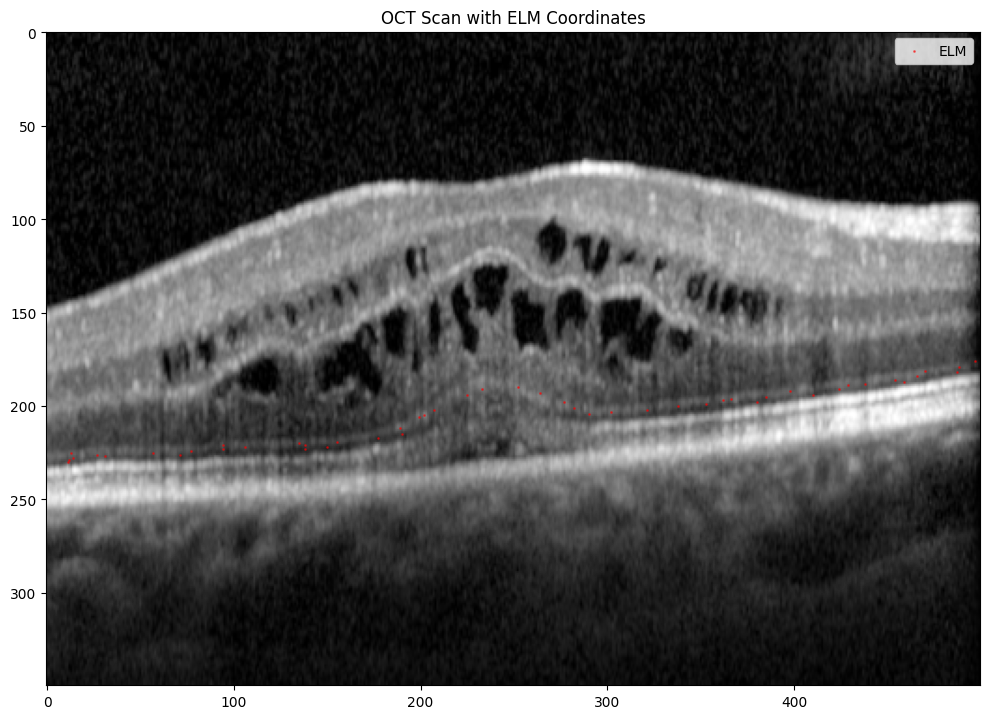

In [63]:
utils.plot_elm(test_scan, test_obs_lp)

In [64]:
test_obs_lp[:, [0, 1]] = test_obs_lp[:, [1, 0]]

In [68]:
gp_kwargs_obs_lp = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 1.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs=test_obs_lp
)

# Instantiate algorithm using parameters in __init__()
noisy_trace_lp = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs_lp)

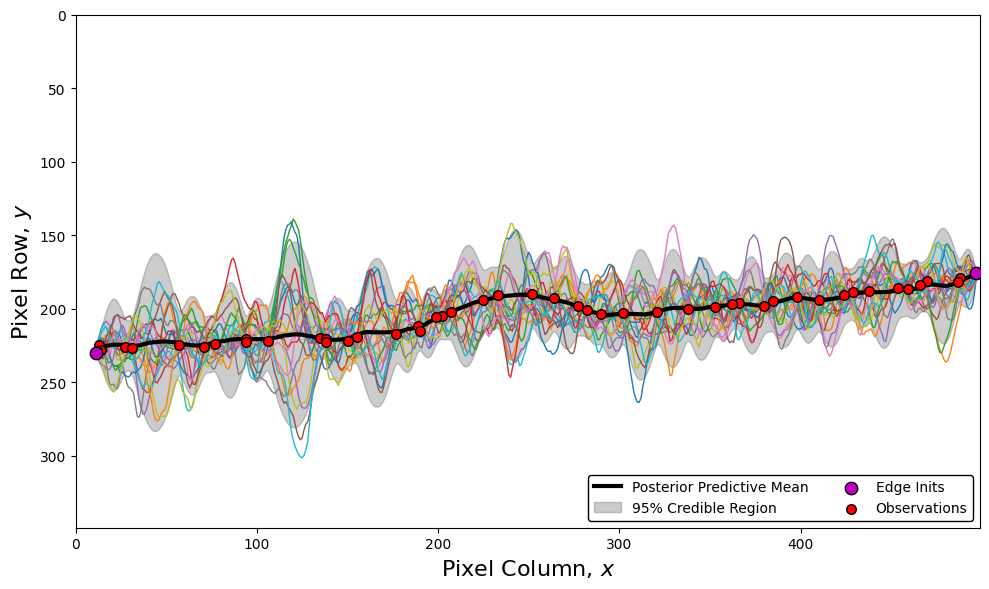

Are you happy with your choice of kernel? y/n
Fitting Gaussian process and computing next set of observations...


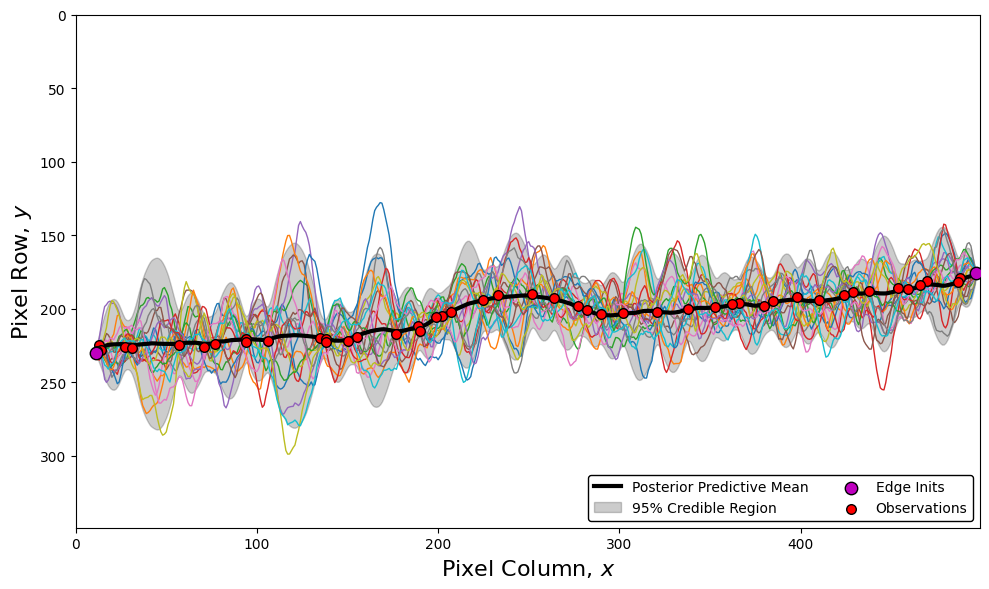

Number of observations: 57
Iteration 2 - Time Elapsed: 0.9627


Time elapsed before algorithm converged: 1.221


In [69]:
# __call__() parameters and run algorithm on test image
print_final_diagnostics = False
show_init_post = True
show_post_iter = True
verbose = True
edge_pred_lp, edge_credint_lp = noisy_trace_lp(print_final_diagnostics,
                                               show_init_post,
                                               show_post_iter,
                                               verbose)

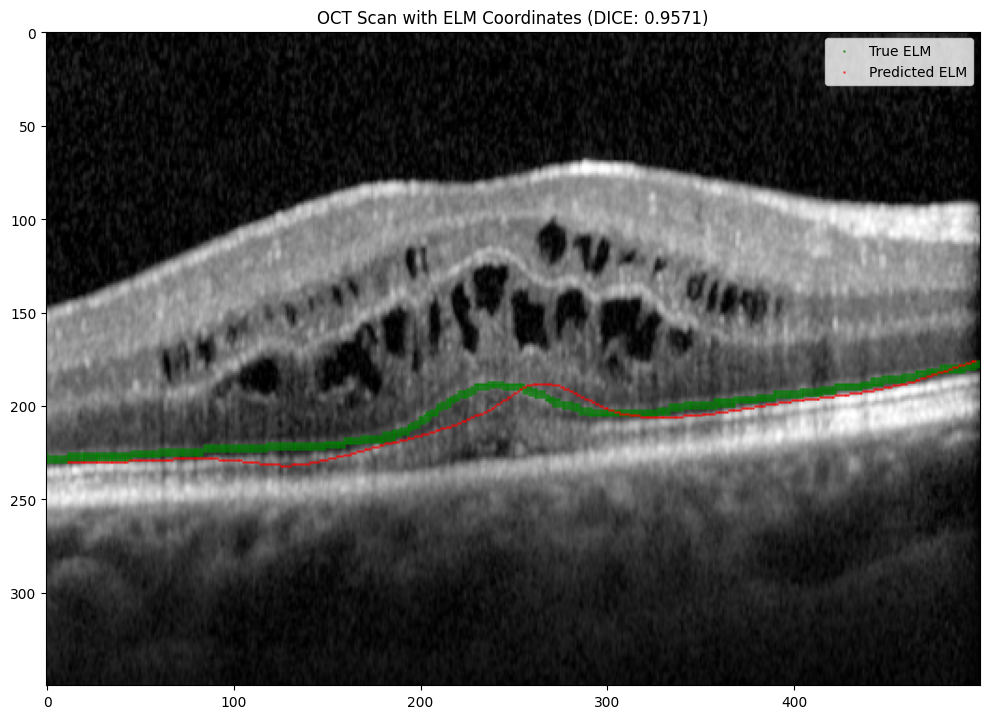

In [70]:
utils.plot_elm(test_scan, edge_pred_lp, compare=True, true_elm_coords=test_elm)